In [1]:
# 앞절에서 수행한 내용들

import os
import numpy as np
from sklearn.datasets import fetch_openml

dataset_root = os.path.join(os.getcwd(), 'datasets')
if not os.path.isdir(dataset_root):
    os.mkdir(dataset_root)
    
mnist = fetch_openml('mnist_784', version=1, data_home=dataset_root)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Error Analysis

실제 머신러닝 프로젝트라면, Appendix B에 있는 Machine Learning project checklist를 따라 여러 단계를 수행해야하지만, 여기서는 적당한 모델을 찾았다고 가정하고, 이 모델의 성능을 향상시키는 방법을 알아보자.

모델의 성능을 향상시키는 방법 중 하나는 error의 type을 분석하는 것이다. 먼저, confusion matrix를 살펴보자.

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

sgd_clf = SGDClassifier(random_state=42)

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


위의 숫자로만 이루어진 matrix는 matplotlib의 `matshow()`를 사용하면 보기 좋게 나타낼 수 있다.

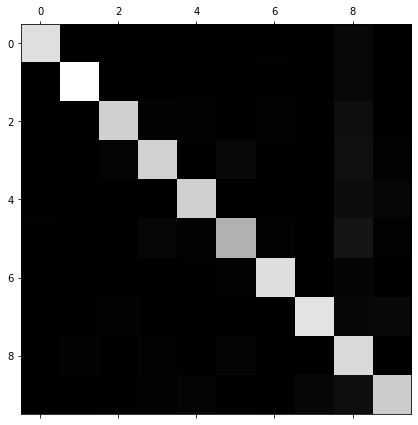

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

diagonal 성분만 밝게 나타난 것은 분류가 잘 되었다는 결과이다. 하지만 여기서 5 class부분이 조금 어둡게 나타났는데, 이는 dataset에 5 class의 이미지가 적거나 classifier가 다른 class들에 비해 5 class를 잘 분류하지 못한다는 의미이다.

먼저, Error를 집중해서 살펴보자. confusion matrix의 각 값들을 해당하는 class의 이미지 수로 나누면 실제 error 수 대신에 error rate를 비교할 수 있다.(이는 많은 이미지를 가진 class에 불공평하게 보일 수 있음)

In [5]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

위 결과에서 diagonal 성분은 0으로 만들어 error만 남긴 후, plot해보자.

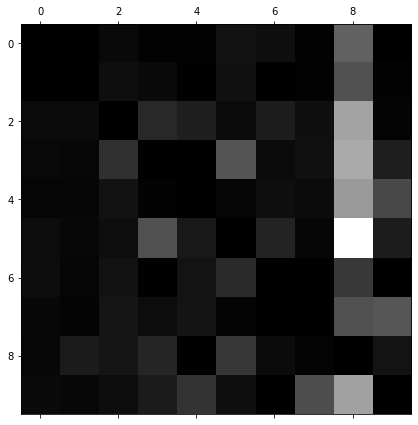

In [6]:
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(7, 7))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

이제 classifier의 유형별 error를 명확하게 볼 수 있게 되었다. row가 actual class, column이 predicted class라는 것을 통해 이를 살펴보자.

class 8의 column이 밝은 것을 보아, 많은 이미지가 8로 잘못 분류된 것을 알 수 있다. 하지만 row는 나쁘지 않으므로, 실제 8은 제대로 8로 분류된다는 것을 알 수 있다.

이처럼 confusion matrix를 분석하는 것은 classifier의 성능을 어떻게 향상시킬 것인지에 대한 insight를 준다. 여기서는 False 8을 줄이는 것에 집중해야 한다는 것을 알 수 있었다. 따라서 8의 데이터를 더 모으거나, 8을 구분하기 위한 feature를 추가하거나, (Sciket-Image, Pillow, OpenCV를 사용해) 이미지에 preprocessing을 추가할 수 있을 것이다.

각 error를 하나하나 분석하는 것도 classifier의 동작과 왜 실패하는지에 대한 insight를 얻을 수 있는 좋은 방법이 될 수 있지만, 이는 매우 어렵고 시간이 많이 드는 작업이다.

예를 들어, 3과 5의 가능한 모든 경우를 살펴보자.

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

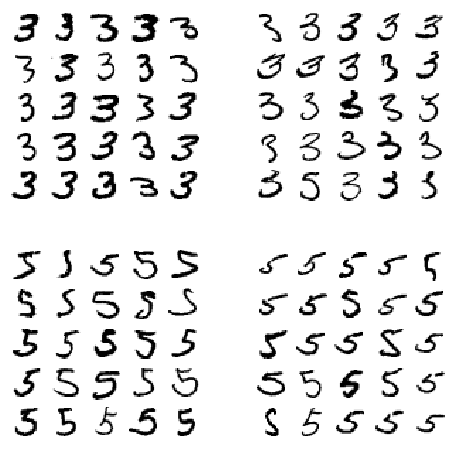

In [8]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

왼쪽의 두 block은 3으로 분류된 것들이고, 오른쪽의 두 block은 5로 분류된 것들이다. 사람도 인식하기 힘든 몇개가 있긴 하지만, 대부분은 잘못 분류된 것이 명확하며 왜 classifier가 이런 실수를 했는지 이해하기 어렵다.

그 이유는 `SGDClassifier`가 linear model이기 때문이다. 이는 각 pixel에 class별 weight를 할당하고, 새 이미지가 주어지면, weighted pixel instensity들을 모두 더해서 class별 score를 구하는 방식이다. 따라서, 이 모델에서 3과 5는 몇개 pixel의 차이일 뿐이므로 쉽게 혼동하게 된다.

이 모델에서 3과 5의 차이점은 상단의 가로선과 하단의 곡선을 연결하는 짧은 선의 위치이다. 만약, 3에서 연결 선을 왼쪽으로 이동시킨다면 5로 분류할 것이고, 그 반대도 마찬가지이다. 

이는 classifier가 이미지의 shifting과 rotation에 매우 민감하다는 뜻이다. 따라서, 이미지의 중앙에 오도록 하고 회전을 줄이도록 preprocessing하는 것이 3과 5의 혼동을 줄일 수 있는 방법이 될 수 있다.